In [168]:
import numpy as np
import pyedflib
import statistics
import plotly.graph_objects as go
import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, ForgetDimension
import random
from sklearn import preprocessing

In [169]:
# Load persistence diagrams

train_persistence_diagrams_label_1 = np.load("Embeddings_and_Persistence_Diagrams/Train_PD1.npy", allow_pickle=True)
test_persistence_diagrams_label_1 = np.load("Embeddings_and_Persistence_Diagrams/Test_PD1.npy", allow_pickle=True)

train_persistence_diagrams_label_3 = np.load("Embeddings_and_Persistence_Diagrams/Train_PD3.npy", allow_pickle=True)
test_persistence_diagrams_label_3 = np.load("Embeddings_and_Persistence_Diagrams/Test_PD3.npy", allow_pickle=True)

train_persistence_diagrams_label_5 = np.load("Embeddings_and_Persistence_Diagrams/Train_PD5.npy", allow_pickle=True)
test_persistence_diagrams_label_5 = np.load("Embeddings_and_Persistence_Diagrams/Test_PD5.npy", allow_pickle=True)

train_persistence_diagrams_label_7 = np.load("Embeddings_and_Persistence_Diagrams/Train_PD7.npy", allow_pickle=True)
test_persistence_diagrams_label_7 = np.load("Embeddings_and_Persistence_Diagrams/Test_PD7.npy", allow_pickle=True)

In [170]:
# Load embeddings

train_embeddings_label_1 = np.load("Embeddings_and_Persistence_Diagrams/Train_Embeddings_PD1.npy", allow_pickle=True)
test_embeddings_label_1 = np.load("Embeddings_and_Persistence_Diagrams/Test_Embeddings_PD1.npy", allow_pickle=True)

train_embeddings_label_3 = np.load("Embeddings_and_Persistence_Diagrams/Train_Embeddings_PD3.npy", allow_pickle=True)
test_embeddings_label_3 = np.load("Embeddings_and_Persistence_Diagrams/Test_Embeddings_PD3.npy", allow_pickle=True)

train_embeddings_label_5 = np.load("Embeddings_and_Persistence_Diagrams/Train_Embeddings_PD5.npy", allow_pickle=True)
test_embeddings_label_5 = np.load("Embeddings_and_Persistence_Diagrams/Test_Embeddings_PD5.npy", allow_pickle=True)

train_embeddings_label_7 = np.load("Embeddings_and_Persistence_Diagrams/Train_Embeddings_PD7.npy", allow_pickle=True)
test_embeddings_label_7 = np.load("Embeddings_and_Persistence_Diagrams/Test_Embeddings_PD7.npy", allow_pickle=True)

# Computing the distance to the Wasserstein Barycenter

## Cutting of noise

For the next analyses, we will need to compare persistence diagrams (pairwise). Giotto TDA needs all diagrams to have the same length for this (to have the same amount of holes). We will therefore cut off some "noise" (holes with low persistence) such that all persistence diagrams have the same length.

In [171]:
# Set number of holes of each dimension that are supposed to be kept
no_holes_per_dimension = [120, 70, 10] 

In [172]:
def cut_diagrams(persistence_diagrams, no_holes_per_dimension):
    # no_holes_per_dimension is a list indicating how many holes for each dimension there should be left
    
    shortened_diagrams = [] # list of diagrams in which non-signicant holes were cut off
    removed_indices = [] # List of indices of the diagrams that are smaller than no_holes_per_dimension and will not be considered

    for diagram_idx, diagram in enumerate(persistence_diagrams): 
        
        most_significant_holes_per_diagram = [] # Holes that are not noise
        should_be_appended = True # Boolean if the diagram index will be added to removed index (False) or not (True)
        holes = {} # Dictionary which will save all holes (values) of each dimension (keys) for each diagram
        
        for hole_dimension, number_of_holes in zip(range(3), no_holes_per_dimension):
            
            # the third entry of each point (hole) in a diagram indicates its dimensionality
            holes[hole_dimension] = diagram[np.where(diagram[:, 2] == hole_dimension)[0]]

            # If the number of holes of this dimension that are supposed to be kept is larger than the number of holes of the diagram
            if number_of_holes > len(holes[hole_dimension]):
                print("Diagram " + str(diagram_idx) + " is shorter than the shortened diagrams, and will be removed")
                print("It has " + str(len(holes[hole_dimension])) + " holes of dimension " + str(hole_dimension))
                should_be_appended = False 
                removed_indices.append(diagram_idx) # Should be sepa rated according to dimension? or not?
                
            # The first and second entries of each hole indicate its birth and death, the difference is the persistence
            # We only want to keep as the as many holes for each dimension as we set no_holes_per_dimension to be
            large_persistence_indices = np.argsort(holes[hole_dimension][:, 0] - holes[hole_dimension][:, 1])[-number_of_holes:]
            
            # For each dimension, getting the holes with the above indices (the holes with the largest persistence)
            significant_holes_with_hole_dimension = holes[hole_dimension][large_persistence_indices, :]
            most_significant_holes_per_diagram.extend(significant_holes_with_hole_dimension)

        if should_be_appended:
            shortened_diagrams.append(most_significant_holes_per_diagram)

    return shortened_diagrams, list(set(removed_indices))

In [173]:
# Label 1

train_shortened_diagrams_label_1, removed_train_indices_label_1 = cut_diagrams(train_persistence_diagrams_label_1, no_holes_per_dimension)
test_shortened_diagrams_label_1, removed_test_indices_label_1 = cut_diagrams(test_persistence_diagrams_label_1, no_holes_per_dimension)

# Remove embeddings of diagrams that were removed 
train_embeddings_label_1 =  np.delete(train_embeddings_label_1, removed_train_indices_label_1, 0)
test_embeddings_label_1 =  np.delete(test_embeddings_label_1, removed_test_indices_label_1, 0)

In [174]:
# Label 3

train_shortened_diagrams_label_3, removed_train_indices_label_3 = cut_diagrams(train_persistence_diagrams_label_3, no_holes_per_dimension)
test_shortened_diagrams_label_3, removed_test_indices_label_3 = cut_diagrams(test_persistence_diagrams_label_3, no_holes_per_dimension)

# Remove embeddings of diagrams that were removed 
train_embeddings_label_3 =  np.delete(train_embeddings_label_3, removed_train_indices_label_3, 0)
test_embeddings_label_3 =  np.delete(test_embeddings_label_3, removed_test_indices_label_3, 0)

Diagram 97 is shorter than the shortened diagrams, and will be removed
It has 9 holes of dimension 2
Diagram 119 is shorter than the shortened diagrams, and will be removed
It has 8 holes of dimension 2
Diagram 208 is shorter than the shortened diagrams, and will be removed
It has 9 holes of dimension 2
Diagram 316 is shorter than the shortened diagrams, and will be removed
It has 8 holes of dimension 2
Diagram 386 is shorter than the shortened diagrams, and will be removed
It has 9 holes of dimension 2
Diagram 562 is shorter than the shortened diagrams, and will be removed
It has 7 holes of dimension 2
Diagram 676 is shorter than the shortened diagrams, and will be removed
It has 8 holes of dimension 2
Diagram 164 is shorter than the shortened diagrams, and will be removed
It has 9 holes of dimension 2
Diagram 324 is shorter than the shortened diagrams, and will be removed
It has 9 holes of dimension 2


In [175]:
# Label 5

train_shortened_diagrams_label_5, removed_train_indices_label_5 = cut_diagrams(train_persistence_diagrams_label_5, no_holes_per_dimension)
test_shortened_diagrams_label_5, removed_test_indices_label_5 = cut_diagrams(test_persistence_diagrams_label_5, no_holes_per_dimension)

# Remove embeddings of diagrams that were removed 
train_embeddings_label_5 =  np.delete(train_embeddings_label_5, removed_train_indices_label_5, 0)
test_embeddings_label_5 =  np.delete(test_embeddings_label_5, removed_test_indices_label_5, 0)

In [176]:
# Label 7

train_shortened_diagrams_label_7, removed_train_indices_label_7 = cut_diagrams(train_persistence_diagrams_label_7, no_holes_per_dimension)
test_shortened_diagrams_label_7, removed_test_indices_label_7 = cut_diagrams(test_persistence_diagrams_label_7, no_holes_per_dimension)

# Remove embeddings of diagrams that were removed 
train_embeddings_label_7 =  np.delete(train_embeddings_label_7, removed_train_indices_label_7, 0)
test_embeddings_label_7 =  np.delete(test_embeddings_label_7, removed_test_indices_label_7, 0)

Diagram 0 is shorter than the shortened diagrams, and will be removed
It has 65 holes of dimension 0
Diagram 0 is shorter than the shortened diagrams, and will be removed
It has 27 holes of dimension 1
Diagram 0 is shorter than the shortened diagrams, and will be removed
It has 6 holes of dimension 2
Diagram 2 is shorter than the shortened diagrams, and will be removed
It has 59 holes of dimension 0
Diagram 2 is shorter than the shortened diagrams, and will be removed
It has 15 holes of dimension 1
Diagram 2 is shorter than the shortened diagrams, and will be removed
It has 1 holes of dimension 2


## Wasserstein Barycenter

The Wasserstein Barycenter is the most representative persistence diagram in a set of diagrams (of one class), so the one with the lowest overall (Wasserstein) distance to all other diagrams. Because it takes long to compute, we will for now only use a part of the data as training data. For now, these training samples can also be in the test set of the simple classifier in the end.

In [177]:
# We will look at 0, 1 and 2 dimensional holes
homology_dimensions = [0, 1, 2]

# We will use a Vietoris Rips filtrations
persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

### Computing the Wasserstein Barycenter for all labels

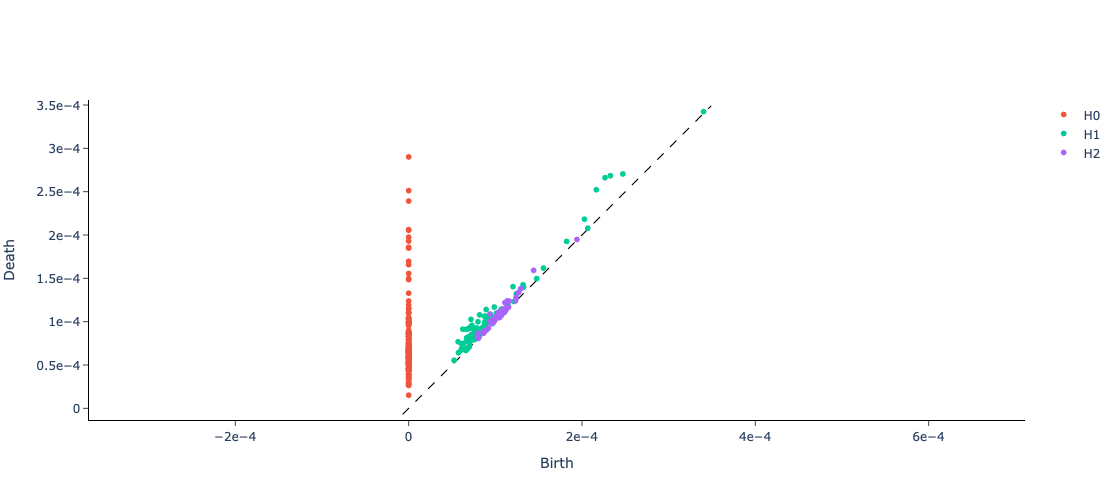

In [178]:
# Finding the most representative diagram for label 1

# Only use parts of the training data to speed things up
random_diagrams_label_1 = random.sample(train_shortened_diagrams_label_1, 100)

# Compute the pairwise Wasserstein distances
pairwise_wasserstein_distances_label_1 = PairwiseDistance(metric="wasserstein").fit_transform(random_diagrams_label_1)

# For each hole, calculate the sum of distances to all other holes
sum_distances = [sum(dist) for dist in pairwise_wasserstein_distances_label_1]

# Find the index of the Wasserstein barycenter
most_representative_index = np.argmin(sum_distances)

# Unshortened Wasserstein Barycenter for label 1
representative_diagram_label_1 = persistence.fit_transform_plot([train_embeddings_label_1[most_representative_index]])

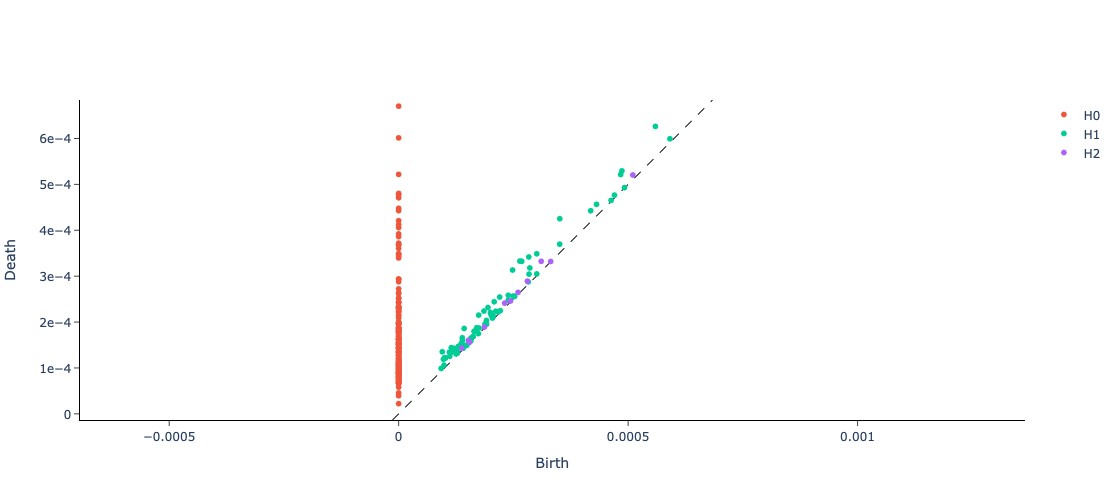

In [179]:
# Finding the most representative diagram for label 3

# Only use parts of the training data to speed things up
random_diagrams_label_3 = random.sample(train_shortened_diagrams_label_3, 100)

# Compute the pairwise Wasserstein distances
pairwise_wasserstein_distances_label_3 = PairwiseDistance(metric="wasserstein").fit_transform(random_diagrams_label_3)

# For each hole, calculate the sum of distances to all other holes
sum_distances = [sum(dist) for dist in pairwise_wasserstein_distances_label_3]

# Find the index of the Wasserstein barycenter
most_representative_index = np.argmin(sum_distances)

# Unshortened Wasserstein Barycenter for label 3
representative_diagram_label_3 = persistence.fit_transform_plot([train_embeddings_label_3[most_representative_index]])

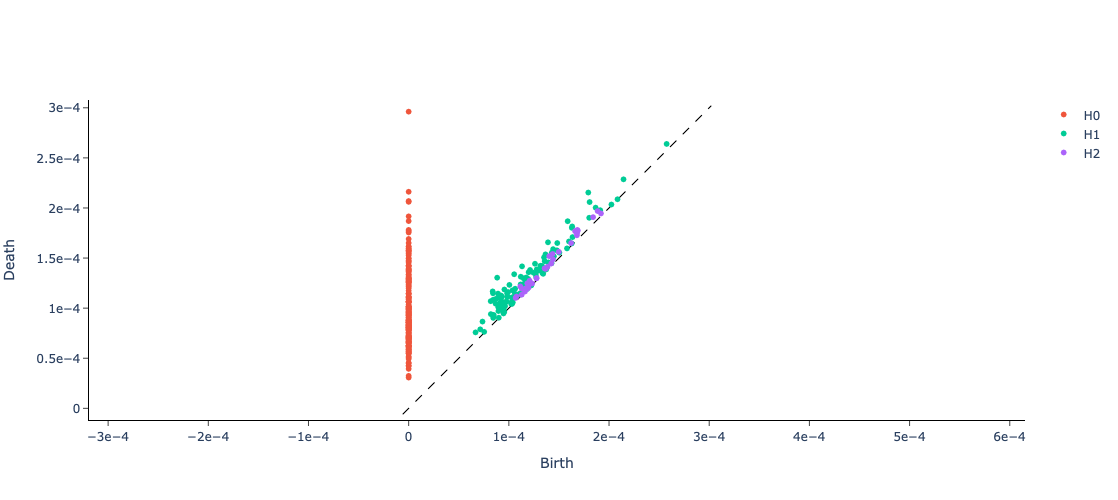

In [180]:
# Finding the most representative diagram for label 5

# Compute the pairwise Wasserstein distances (Use all training data as there are not too many label 5 diagrams)
pairwise_wasserstein_distances_label_5 = PairwiseDistance(metric="wasserstein").fit_transform(train_shortened_diagrams_label_5)

# For each hole, calculate the sum of distances to all other holes
sum_distances = [sum(dist) for dist in pairwise_wasserstein_distances_label_5]

# Find the index of the Wasserstein barycenter
most_representative_index = np.argmin(sum_distances)

# Unshortened Wasserstein Barycenter for label 5
representative_diagram_label_5 = persistence.fit_transform_plot([train_embeddings_label_5[most_representative_index]])

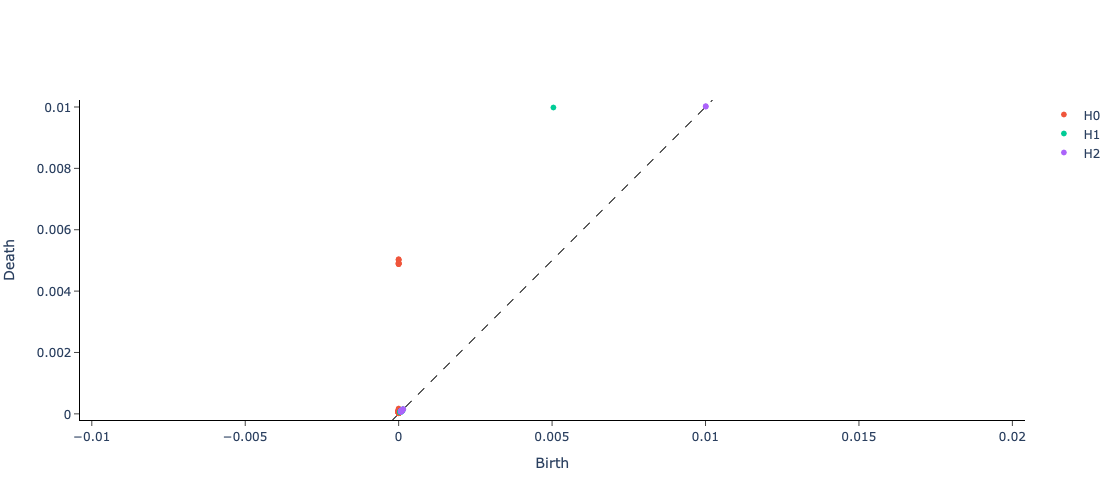

In [181]:
# Finding the most representative diagram for label 7

# First, compute the pairwise Wasserstein distances (Use all training data as there are not too many label 7 diagrams)
pairwise_wasserstein_distances_label_7 = PairwiseDistance(metric="wasserstein").fit_transform(train_shortened_diagrams_label_7)

# For each hole, calculate the sum of distances to all other holes
sum_distances = [sum(dist) for dist in pairwise_wasserstein_distances_label_7]

# Find the index of the Wasserstein barycenter
most_representative_index = np.argmin(sum_distances)

# Unshortened Wasserstein Barycenter for label 7
representative_diagram_label_7 = persistence.fit_transform_plot([train_embeddings_label_7[most_representative_index]])

### Computing the distances of the test diagrams to the most representative diagram of each class

In [182]:
# TODO maybe split cut_diagrams into two functions such that
shortened_barycenter_label_1, _ = cut_diagrams([representative_diagram_label_1[0]], no_holes_per_dimension)
shortened_barycenter_label_3, _ = cut_diagrams([representative_diagram_label_3[0]], no_holes_per_dimension)
shortened_barycenter_label_5, _ = cut_diagrams([representative_diagram_label_5[0]], no_holes_per_dimension)
shortened_barycenter_label_7, _ = cut_diagrams([representative_diagram_label_7[0]], no_holes_per_dimension)

#### Label 1

In [183]:
# TRAIN DATA 

# Distance of label 1 train diagrams to barycenters of each class
train_label_1_distances_to_barycenter_1 = []
train_label_1_distances_to_barycenter_3 = []
train_label_1_distances_to_barycenter_5 = []
train_label_1_distances_to_barycenter_7 = []

# Loop through all train diagrams of label 1
for diagram in train_shortened_diagrams_label_1:
    # Barycenter of class 1
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_1[0]])
    train_label_1_distances_to_barycenter_1.append(max(dist[0]))

    # Barycenter of class 3
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_3[0]])
    train_label_1_distances_to_barycenter_3.append(max(dist[0]))

    # Barycenter of class 5
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_5[0]])
    train_label_1_distances_to_barycenter_5.append(max(dist[0]))

    # Barycenter of class 7
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_7[0]])
    train_label_1_distances_to_barycenter_7.append(max(dist[0]))

In [184]:
# TEST DATA 

# Distance of label 1 test diagrams to barycenters of each class
test_label_1_distances_to_barycenter_1 = []
test_label_1_distances_to_barycenter_3 = []
test_label_1_distances_to_barycenter_5 = []
test_label_1_distances_to_barycenter_7 = []

# Loop through all test diagrams of label 1
for diagram in test_shortened_diagrams_label_1:
    # Barycenter of class 1
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_1[0]])
    test_label_1_distances_to_barycenter_1.append(max(dist[0]))

    # Barycenter of class 3
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_3[0]])
    test_label_1_distances_to_barycenter_3.append(max(dist[0]))

    # Barycenter of class 5
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_5[0]])
    test_label_1_distances_to_barycenter_5.append(max(dist[0]))

    # Barycenter of class 7
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_7[0]])
    test_label_1_distances_to_barycenter_7.append(max(dist[0]))


print("Mean distance of class 1 diagrams to class 1 Wasserstein barycenter: " + str(statistics.mean(test_label_1_distances_to_barycenter_1)))
print("Mean distance of class 1 diagrams to class 3 Wasserstein barycenter: " + str(statistics.mean(test_label_1_distances_to_barycenter_3)))
print("Mean distance of class 1 diagrams to class 5 Wasserstein barycenter: " + str(statistics.mean(test_label_1_distances_to_barycenter_5)))
print("Mean distance of class 1 diagrams to class 7 Wasserstein barycenter: " + str(statistics.mean(test_label_1_distances_to_barycenter_7)))

Mean distance of class 1 diagrams to class 1 Wasserstein barycenter: 7.577746698450201e-05
Mean distance of class 1 diagrams to class 3 Wasserstein barycenter: 0.0005737054192338327
Mean distance of class 1 diagrams to class 5 Wasserstein barycenter: 0.0002219497835853783
Mean distance of class 1 diagrams to class 7 Wasserstein barycenter: 8.927790221263975e-05


#### Label 3

In [185]:
# TRAIN DATA

# Distance of label 3 train diagrams to barycenters of each class
train_label_3_distances_to_barycenter_1 = []
train_label_3_distances_to_barycenter_3 = []
train_label_3_distances_to_barycenter_5 = []
train_label_3_distances_to_barycenter_7 = []

# Loop through all train diagrams of label 3
for diagram in train_shortened_diagrams_label_3:

    # Barycenter of class 1
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_1[0]])
    train_label_3_distances_to_barycenter_1.append(max(dist[0]))

    # Barycenter of class 3
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_3[0]])
    train_label_3_distances_to_barycenter_3.append(max(dist[0]))

    # Barycenter of class 5
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_5[0]])
    train_label_3_distances_to_barycenter_5.append(max(dist[0]))

    # Barycenter of class 7
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_7[0]])
    train_label_3_distances_to_barycenter_7.append(max(dist[0]))

In [186]:
# TEST DATA

# Distance of label 3 test diagrams to barycenters of each class
test_label_3_distances_to_barycenter_1 = []
test_label_3_distances_to_barycenter_3 = []
test_label_3_distances_to_barycenter_5 = []
test_label_3_distances_to_barycenter_7 = []

# Loop through all test diagrams of label 3
for diagram in test_shortened_diagrams_label_3:

    # Barycenter of class 1
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_1[0]])
    test_label_3_distances_to_barycenter_1.append(max(dist[0]))

    # Barycenter of class 3
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_3[0]])
    test_label_3_distances_to_barycenter_3.append(max(dist[0]))

    # Barycenter of class 5
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_5[0]])
    test_label_3_distances_to_barycenter_5.append(max(dist[0]))

    # Barycenter of class 7
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_7[0]])
    test_label_3_distances_to_barycenter_7.append(max(dist[0]))


print("Mean distance of class 1 diagrams to class 1 Wasserstein barycenter: " + str(statistics.mean(test_label_3_distances_to_barycenter_1)))
print("Mean distance of class 1 diagrams to class 3 Wasserstein barycenter: " + str(statistics.mean(test_label_3_distances_to_barycenter_3)))
print("Mean distance of class 1 diagrams to class 5 Wasserstein barycenter: " + str(statistics.mean(test_label_3_distances_to_barycenter_5)))
print("Mean distance of class 1 diagrams to class 7 Wasserstein barycenter: " + str(statistics.mean(test_label_3_distances_to_barycenter_7)))

Mean distance of class 1 diagrams to class 1 Wasserstein barycenter: 0.0005137708187742989
Mean distance of class 1 diagrams to class 3 Wasserstein barycenter: 0.00021031808229450677
Mean distance of class 1 diagrams to class 5 Wasserstein barycenter: 0.00033680868879289313
Mean distance of class 1 diagrams to class 7 Wasserstein barycenter: 0.0005364139776694894


#### Label 5

In [187]:
# TRAIN DATA

# Distance of label 5 train diagrams to barycenters of each class
train_label_5_distances_to_barycenter_1 = []
train_label_5_distances_to_barycenter_3 = []
train_label_5_distances_to_barycenter_5 = []
train_label_5_distances_to_barycenter_7 = []

# Loop through all train diagrams of label 5
for diagram in train_shortened_diagrams_label_5:

    # Barycenter of class 1
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_1[0]])
    train_label_5_distances_to_barycenter_1.append(max(dist[0]))

    # Barycenter of class 3
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_3[0]])
    train_label_5_distances_to_barycenter_3.append(max(dist[0]))

    # Barycenter of class 5
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_5[0]])
    train_label_5_distances_to_barycenter_5.append(max(dist[0]))

    # Barycenter of class 7
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_7[0]])
    train_label_5_distances_to_barycenter_7.append(max(dist[0]))

In [188]:
# TEST DATA

# Distance of label 5 test diagrams to barycenters of each class
test_label_5_distances_to_barycenter_1 = []
test_label_5_distances_to_barycenter_3 = []
test_label_5_distances_to_barycenter_5 = []
test_label_5_distances_to_barycenter_7 = []

# Loop through all test diagrams of label 5
for diagram in test_shortened_diagrams_label_5:

    # Barycenter of class 1
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_1[0]])
    test_label_5_distances_to_barycenter_1.append(max(dist[0]))

    # Barycenter of class 3
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_3[0]])
    test_label_5_distances_to_barycenter_3.append(max(dist[0]))

    # Barycenter of class 5
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_5[0]])
    test_label_5_distances_to_barycenter_5.append(max(dist[0]))

    # Barycenter of class 7
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_7[0]])
    test_label_5_distances_to_barycenter_7.append(max(dist[0]))


print("Mean distance of class 1 diagrams to class 1 Wasserstein barycenter: " + str(statistics.mean(test_label_5_distances_to_barycenter_1)))
print("Mean distance of class 1 diagrams to class 3 Wasserstein barycenter: " + str(statistics.mean(test_label_5_distances_to_barycenter_3)))
print("Mean distance of class 1 diagrams to class 5 Wasserstein barycenter: " + str(statistics.mean(test_label_5_distances_to_barycenter_5)))
print("Mean distance of class 1 diagrams to class 7 Wasserstein barycenter: " + str(statistics.mean(test_label_5_distances_to_barycenter_7)))

Mean distance of class 1 diagrams to class 1 Wasserstein barycenter: 0.0002187620709582212
Mean distance of class 1 diagrams to class 3 Wasserstein barycenter: 0.0004453372191384985
Mean distance of class 1 diagrams to class 5 Wasserstein barycenter: 0.00011063600887067381
Mean distance of class 1 diagrams to class 7 Wasserstein barycenter: 0.0002597641257310417


#### Label 7

In [189]:
# TRAIN DATA

# Distance of label 5 train diagrams to barycenters of each class
train_label_7_distances_to_barycenter_1 = []
train_label_7_distances_to_barycenter_3 = []
train_label_7_distances_to_barycenter_5 = []
train_label_7_distances_to_barycenter_7 = []

# Loop through all train diagrams of label 5
for diagram in train_shortened_diagrams_label_7:

    # Barycenter of class 1
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_1[0]])
    train_label_7_distances_to_barycenter_1.append(max(dist[0]))

    # Barycenter of class 3
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_3[0]])
    train_label_7_distances_to_barycenter_3.append(max(dist[0]))

    # Barycenter of class 5
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_5[0]])
    train_label_7_distances_to_barycenter_5.append(max(dist[0]))

    # Barycenter of class 7
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_7[0]])
    train_label_7_distances_to_barycenter_7.append(max(dist[0]))

In [190]:
# TEST DATA

# Distance of label 5 test diagrams to barycenters of each class
test_label_7_distances_to_barycenter_1 = []
test_label_7_distances_to_barycenter_3 = []
test_label_7_distances_to_barycenter_5 = []
test_label_7_distances_to_barycenter_7 = []

# Loop through all test diagrams of label 5
for diagram in test_shortened_diagrams_label_7:

    # Barycenter of class 1
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_1[0]])
    test_label_7_distances_to_barycenter_1.append(max(dist[0]))

    # Barycenter of class 3
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_3[0]])
    test_label_7_distances_to_barycenter_3.append(max(dist[0]))

    # Barycenter of class 5
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_5[0]])
    test_label_7_distances_to_barycenter_5.append(max(dist[0]))

    # Barycenter of class 7
    dist = PairwiseDistance(metric="wasserstein").fit_transform([diagram, shortened_barycenter_label_7[0]])
    test_label_7_distances_to_barycenter_7.append(max(dist[0]))


print("Mean distance of class 1 diagrams to class 1 Wasserstein barycenter: " + str(statistics.mean(test_label_7_distances_to_barycenter_1)))
print("Mean distance of class 1 diagrams to class 3 Wasserstein barycenter: " + str(statistics.mean(test_label_7_distances_to_barycenter_3)))
print("Mean distance of class 1 diagrams to class 5 Wasserstein barycenter: " + str(statistics.mean(test_label_7_distances_to_barycenter_5)))
print("Mean distance of class 1 diagrams to class 7 Wasserstein barycenter: " + str(statistics.mean(test_label_7_distances_to_barycenter_7)))

Mean distance of class 1 diagrams to class 1 Wasserstein barycenter: 0.00015166816364820928
Mean distance of class 1 diagrams to class 3 Wasserstein barycenter: 0.0005294778284200137
Mean distance of class 1 diagrams to class 5 Wasserstein barycenter: 0.0001682024223043851
Mean distance of class 1 diagrams to class 7 Wasserstein barycenter: 0.00016016417409999676


## Save Wasserstein distances

In [191]:
# Add the removed diagrams again, with a distance that is higher than the maximal distance out of the other diagrams
# At a later step, the "outlier" diagrams should be labelled as outliers beforehand

# Compute maximal distances per class
maximal_distance_1 = np.max(pairwise_wasserstein_distances_label_1)
maximal_distance_3 = np.max(pairwise_wasserstein_distances_label_3)
maximal_distance_5 = np.max(pairwise_wasserstein_distances_label_5)
maximal_distance_7 = np.max(pairwise_wasserstein_distances_label_7)

# Add ten times the maximal distance to the indices that were removed before
# TODO put this into a function

# Label 1
for idx in removed_train_indices_label_1: # Train data
    train_label_1_distances_to_barycenter_1.insert(idx, maximal_distance_1*10)
    train_label_1_distances_to_barycenter_3.insert(idx, maximal_distance_3*10)
    train_label_1_distances_to_barycenter_5.insert(idx, maximal_distance_5*10)
    train_label_1_distances_to_barycenter_7.insert(idx, maximal_distance_7*10)

for idx in removed_test_indices_label_1: # test data
    test_label_1_distances_to_barycenter_1.insert(idx, maximal_distance_1*10)
    test_label_1_distances_to_barycenter_3.insert(idx, maximal_distance_3*10)
    test_label_1_distances_to_barycenter_5.insert(idx, maximal_distance_5*10)
    test_label_1_distances_to_barycenter_7.insert(idx, maximal_distance_7*10)


# Label 3
for idx in removed_train_indices_label_3: # Train data
    train_label_3_distances_to_barycenter_1.insert(idx, maximal_distance_1*10)
    train_label_3_distances_to_barycenter_3.insert(idx, maximal_distance_3*10)
    train_label_3_distances_to_barycenter_5.insert(idx, maximal_distance_5*10)
    train_label_3_distances_to_barycenter_7.insert(idx, maximal_distance_7*10)

for idx in removed_test_indices_label_3: # test data
    test_label_3_distances_to_barycenter_1.insert(idx, maximal_distance_1*10)
    test_label_3_distances_to_barycenter_3.insert(idx, maximal_distance_3*10)
    test_label_3_distances_to_barycenter_5.insert(idx, maximal_distance_5*10)
    test_label_3_distances_to_barycenter_7.insert(idx, maximal_distance_7*10)


# Label 5
for idx in removed_train_indices_label_5: # Train data
    train_label_5_distances_to_barycenter_1.insert(idx, maximal_distance_1*10)
    train_label_5_distances_to_barycenter_3.insert(idx, maximal_distance_3*10)
    train_label_5_distances_to_barycenter_5.insert(idx, maximal_distance_5*10)
    train_label_5_distances_to_barycenter_7.insert(idx, maximal_distance_7*10)

for idx in removed_test_indices_label_5: # test data
    test_label_5_distances_to_barycenter_1.insert(idx, maximal_distance_1*10)
    test_label_5_distances_to_barycenter_3.insert(idx, maximal_distance_3*10)
    test_label_5_distances_to_barycenter_5.insert(idx, maximal_distance_5*10)
    test_label_5_distances_to_barycenter_7.insert(idx, maximal_distance_7*10)


# Label 7
for idx in removed_train_indices_label_7: # Train data
    train_label_7_distances_to_barycenter_1.insert(idx, maximal_distance_1*10)
    train_label_7_distances_to_barycenter_3.insert(idx, maximal_distance_3*10)
    train_label_7_distances_to_barycenter_5.insert(idx, maximal_distance_5*10)
    train_label_7_distances_to_barycenter_7.insert(idx, maximal_distance_7*10)

for idx in removed_test_indices_label_7: # test data
    test_label_7_distances_to_barycenter_1.insert(idx, maximal_distance_1*10)
    test_label_7_distances_to_barycenter_3.insert(idx, maximal_distance_3*10)
    test_label_7_distances_to_barycenter_5.insert(idx, maximal_distance_5*10)
    test_label_7_distances_to_barycenter_7.insert(idx, maximal_distance_7*10)

In [192]:
len(train_persistence_diagrams_label_1)

591

In [193]:
# Save training data features

train_feature_df1 = pd.DataFrame()
train_feature_df1["Distance_to_Wasserstein_Barycenter1"] = train_label_1_distances_to_barycenter_1
train_feature_df1["Distance_to_Wasserstein_Barycenter3"] = train_label_1_distances_to_barycenter_3
train_feature_df1["Distance_to_Wasserstein_Barycenter5"] = train_label_1_distances_to_barycenter_5
train_feature_df1["Distance_to_Wasserstein_Barycenter7"] = train_label_1_distances_to_barycenter_7
train_feature_df1["Label"] = 1

train_feature_df3 = pd.DataFrame()
train_feature_df3["Distance_to_Wasserstein_Barycenter1"] = train_label_3_distances_to_barycenter_1
train_feature_df3["Distance_to_Wasserstein_Barycenter3"] = train_label_3_distances_to_barycenter_3
train_feature_df3["Distance_to_Wasserstein_Barycenter5"] = train_label_3_distances_to_barycenter_5
train_feature_df3["Distance_to_Wasserstein_Barycenter7"] = train_label_3_distances_to_barycenter_7
train_feature_df3["Label"] = 3

train_feature_df5 = pd.DataFrame()
train_feature_df5["Distance_to_Wasserstein_Barycenter1"] = train_label_5_distances_to_barycenter_1
train_feature_df5["Distance_to_Wasserstein_Barycenter3"] = train_label_5_distances_to_barycenter_3
train_feature_df5["Distance_to_Wasserstein_Barycenter5"] = train_label_5_distances_to_barycenter_5
train_feature_df5["Distance_to_Wasserstein_Barycenter7"] = train_label_5_distances_to_barycenter_7
train_feature_df5["Label"] = 5

train_feature_df7 = pd.DataFrame()
train_feature_df7["Distance_to_Wasserstein_Barycenter1"] = train_label_7_distances_to_barycenter_1
train_feature_df7["Distance_to_Wasserstein_Barycenter3"] = train_label_7_distances_to_barycenter_3
train_feature_df7["Distance_to_Wasserstein_Barycenter5"] = train_label_7_distances_to_barycenter_5
train_feature_df7["Distance_to_Wasserstein_Barycenter7"] = train_label_7_distances_to_barycenter_7
train_feature_df7["Label"] = 7


In [194]:
train_feature_df = pd.concat([train_feature_df1, train_feature_df3, train_feature_df5, train_feature_df7])
train_feature_df.to_csv("Features/Train_Wasserstein_Features.csv")

In [195]:
# Save test data features

test_feature_df1 = pd.DataFrame()
test_feature_df1["Distance_to_Wasserstein_Barycenter1"] = test_label_1_distances_to_barycenter_1
test_feature_df1["Distance_to_Wasserstein_Barycenter3"] = test_label_1_distances_to_barycenter_3
test_feature_df1["Distance_to_Wasserstein_Barycenter5"] = test_label_1_distances_to_barycenter_5
test_feature_df1["Distance_to_Wasserstein_Barycenter7"] = test_label_1_distances_to_barycenter_7
test_feature_df1["Label"] = 1

test_feature_df3 = pd.DataFrame()
test_feature_df3["Distance_to_Wasserstein_Barycenter1"] = test_label_3_distances_to_barycenter_1
test_feature_df3["Distance_to_Wasserstein_Barycenter3"] = test_label_3_distances_to_barycenter_3
test_feature_df3["Distance_to_Wasserstein_Barycenter5"] = test_label_3_distances_to_barycenter_5
test_feature_df3["Distance_to_Wasserstein_Barycenter7"] = test_label_3_distances_to_barycenter_7
test_feature_df3["Label"] = 3

test_feature_df5 = pd.DataFrame()
test_feature_df5["Distance_to_Wasserstein_Barycenter1"] = test_label_5_distances_to_barycenter_1
test_feature_df5["Distance_to_Wasserstein_Barycenter3"] = test_label_5_distances_to_barycenter_3
test_feature_df5["Distance_to_Wasserstein_Barycenter5"] = test_label_5_distances_to_barycenter_5
test_feature_df5["Distance_to_Wasserstein_Barycenter7"] = test_label_5_distances_to_barycenter_7
test_feature_df5["Label"] = 5

test_feature_df7 = pd.DataFrame()
test_feature_df7["Distance_to_Wasserstein_Barycenter1"] = test_label_7_distances_to_barycenter_1
test_feature_df7["Distance_to_Wasserstein_Barycenter3"] = test_label_7_distances_to_barycenter_3
test_feature_df7["Distance_to_Wasserstein_Barycenter5"] = test_label_7_distances_to_barycenter_5
test_feature_df7["Distance_to_Wasserstein_Barycenter7"] = test_label_7_distances_to_barycenter_7
test_feature_df7["Label"] = 7


In [196]:
test_feature_df = pd.concat([test_feature_df1, test_feature_df3, test_feature_df5, test_feature_df7])
test_feature_df.to_csv("Features/Test_Wasserstein_Features.csv")

## Save shortened diagrams

...